# Project M4: Repetition or Structure? Exploring Color Consistency in Bob Ross Paintings
**Student Name:** Tianqi Sun  
**Team:** B1 Team 15

### 1. Refined Problem Statement & Focus
**My Focus:** Does Bob Ross's specific color palette structure evolve significantly across seasons, or is it fundamentally anchored by the semantic themes (e.g., "Winter", "Mountain") of the paintings?

**What changed from M2/M3:** In M2, I mistakenly applied Principal Component Analysis (PCA) to binary pigment data, yielding an unacceptably low explained variance, and I discarded critical metadata (titles and seasons). For my M4 refinement, I reinstated the metadata and utilized a HuggingFace pre-trained neural network (`all-MiniLM-L6-v2`) to generate dense semantic embeddings of the painting titles. This is followed by PCA noise reduction, K-Means clustering, and segmented Association Rules.

**Formal Hypotheses:**
* **H1 (Theme Anchored):** Within a specific semantic theme, the core pigment association rules remain highly consistent between early and late seasons.
* **H2 (Temporal Drift):** If stylistic drift exists, the rule sets and their support/lift metrics will change significantly across time segments, even within the same theme.

In [49]:
%%capture
!pip install sentence-transformers mlxtend

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging
from google.colab import drive

warnings.filterwarnings('ignore')
logging.getLogger("sentence_transformers").setLevel(logging.ERROR)
logging.getLogger("transformers").setLevel(logging.ERROR)

drive.mount('/content/drive')

In [50]:
file_path = "/content/drive/MyDrive/BA820_Project/Data/Bob_Ross/bob_ross.csv"
df = pd.read_csv(file_path)


df['painting_title'] = df['painting_title'].str.strip()

non_color_cols = ['painting_index', 'img_src', 'painting_title', 'season', 'episode',
                  'num_colors', 'youtube_src', 'colors', 'color_hex', 'text_cluster']

non_color_cols = [c for c in non_color_cols if c in df.columns]
pigment_cols = [col for col in df.columns if col not in non_color_cols]

for col in pigment_cols:
    df[col] = df[col].astype(bool)

print(f"Dataset shape: {df.shape}")
print("Reinstated metadata features:")
display(df[['season', 'episode', 'painting_title']].head(3))

Dataset shape: (403, 27)
Reinstated metadata features:


,season,episode,painting_title
0,1,1,A Walk in the Woods
1,1,2,Mt. McKinley
2,1,3,Ebony Sunset


### 2. Method Upgrade: Deep Learning Neural Embeddings & PCA
To capture the true semantic meaning of the paintings, I transitioned from simple keyword matching to dense neural embeddings. Deep learning features often contain specific semantic noise, so I apply PCA to retain 85% of the variance.

In [51]:
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

model = SentenceTransformer('all-MiniLM-L6-v2')
titles = df['painting_title'].tolist()
X_text_neural = model.encode(titles)

pca = PCA(n_components=0.85, random_state=42)
X_pca = pca.fit_transform(X_text_neural)

total_variance = pca.explained_variance_ratio_.sum()

print(f"Original neural embedding dimensions: {X_text_neural.shape[1]}")
print(f"PCA components retained for 85% variance: {pca.n_components_}")
print(f"Total explained variance: {total_variance:.4f}")

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

Original neural embedding dimensions: 384
PCA components retained for 85% variance: 74
Total explained variance: 0.8501


### 3. Experimental Rigor & Technical Challenges: Tuning K
**Challenge Encountered:** When plotting the Silhouette score and Inertia, K=7 actually yields a higher silhouette score than K=4. However, choosing K=7 leads to extreme fragmentation. This makes rule mining unstable and underpowered due to very small within-cluster sample sizes.
**Adjustment:** I chose **K=4** because it represents the optimal trade-off between mathematical cluster separation (a clear elbow in inertia) and domain interpretability, ensuring enough samples per theme for robust rule mining.

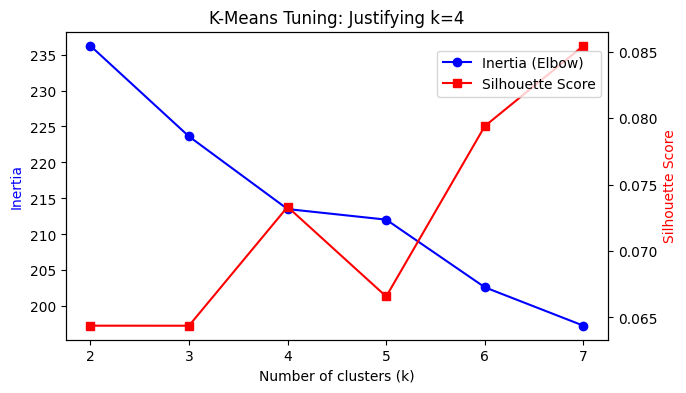

In [52]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertias = []
silhouettes = []
K_range = range(2, 8)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42).fit(X_pca)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_pca, km.labels_))

fig, ax1 = plt.subplots(figsize=(7, 4))
ax1.plot(K_range, inertias, 'bo-', label='Inertia (Elbow)')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia', color='b')

ax2 = ax1.twinx()
ax2.plot(K_range, silhouettes, 'rs-', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='r')

plt.title('K-Means Tuning: Justifying k=4')
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.85))
plt.show()

### 4. Semantic Clustering and Dynamic Theme Identification
Instead of relying on flawed string-matching to identify specific clusters (e.g., searching for the word "Winter"), I encode the target concept ("Winter landscapes and snow") using the same neural network and find the cluster centroid closest to this concept in the vector space.

In [53]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
df['text_cluster'] = kmeans.fit_predict(X_pca)

print("Sample titles per semantic cluster:")
for cluster_id in range(k):
    samples = df[df['text_cluster'] == cluster_id]['painting_title'].head(4).tolist()
    print(f"Cluster {cluster_id}: {samples}")

winter_concept_vector = model.encode(["Winter landscapes and snow"])
winter_concept_pca = pca.transform(winter_concept_vector)

distances_to_winter = [np.linalg.norm(winter_concept_pca - centroid) for centroid in kmeans.cluster_centers_]
winter_cluster_id = np.argmin(distances_to_winter)

print(f"\nSemantic Vector Matching: Cluster {winter_cluster_id} is mathematically closest to the concept of 'Winter'.")

Sample titles per semantic cluster:
Cluster 0: ['Ebony Sunset', 'Seascape', 'Final Reflections', 'Ebony Sea']
Cluster 1: ['Mt. McKinley', 'Autumn Mountain', 'Mountain Lake', 'Brown Mountain']
Cluster 2: ['A Walk in the Woods', 'Quiet Stream', 'Peaceful Valley', 'Meadow Lake']
Cluster 3: ['Winter Mist', 'Winter Moon', 'Winter Glow', 'Snow Fall']

Semantic Vector Matching: Cluster 3 is mathematically closest to the concept of 'Winter'.


### 5. Semantic-Driven Association Rules & Pruning Strategy
**Dead End & Challenge:** Initially, running the Apriori algorithm with `support=0.25` generated over 110,000 rules. This "rule explosion" made interpretation impossible and the conclusions defenseless.
**Adjustment (Pruning):** To extract only the most meaningful, actionable pigment recipes, I applied a strict pruning strategy:
1. **Length Restriction (`max_len=3`):** Limited itemsets to a maximum of 3 pigments.
2. **Support (0.35) & Lift (> 1.1):** High support ensures the recipe is truly fundamental to the theme, while lift > 1.1 filters out ubiquitous colors (like Titanium White) that merely co-occur by random chance.

In [54]:
from mlxtend.frequent_patterns import apriori, association_rules

def get_pruned_rules(df_subset, min_support=0.35, min_lift=1.1):
    frequent_itemsets = apriori(df_subset[pigment_cols], min_support=min_support, max_len=3, use_colnames=True)
    if frequent_itemsets.empty:
        return pd.DataFrame()
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=min_lift)

    rules['ante_len'] = rules['antecedents'].apply(lambda x: len(x))
    rules['cons_len'] = rules['consequents'].apply(lambda x: len(x))
    clean_rules = rules[(rules['ante_len'] <= 2) & (rules['cons_len'] == 1)]

    return clean_rules.sort_values(by='lift', ascending=False).drop(columns=['ante_len', 'cons_len'])

theme_winter_df = df[df['text_cluster'] == winter_cluster_id]

print("Sensitivity Analysis for Winter Theme (with strict structure pruning):")
for supp in [0.25, 0.30, 0.35]:
    test_rules = get_pruned_rules(theme_winter_df, min_support=supp)
    num_rules = len(test_rules) if isinstance(test_rules, pd.DataFrame) and not test_rules.empty else 0
    print(f"Min_Support = {supp} -> Found {num_rules} core interpretable rules.")

Sensitivity Analysis for Winter Theme (with strict structure pruning):
Min_Support = 0.25 -> Found 387 core interpretable rules.
Min_Support = 0.3 -> Found 351 core interpretable rules.
Min_Support = 0.35 -> Found 303 core interpretable rules.


### 6. Temporal Consistency (Answering SQ3) with Jaccard Similarity
To test **H1 vs H2**, I split the "Winter" theme chronologically (Early: Seasons 1-10 vs. Late: Seasons 21-31). I use the **Jaccard Similarity index** on the Top 30 rules (ranked by Lift) to quantify how much the core pigment combinations overlap across decades.

In [55]:
early_season = theme_winter_df[theme_winter_df['season'] <= 10]
late_season = theme_winter_df[theme_winter_df['season'] > 20]

r_early = get_pruned_rules(early_season, min_support=0.35)
r_late = get_pruned_rules(late_season, min_support=0.35)

print("Winter Theme: Early Seasons (1-10) Top 3")
display(r_early[['antecedents', 'consequents', 'support', 'lift']].head(3) if not r_early.empty else "No rules")

print("Winter Theme: Late Seasons (21-31) Top 3")
display(r_late[['antecedents', 'consequents', 'support', 'lift']].head(3) if not r_late.empty else "No rules")

def extract_rule_strings(rules_df, top_n=30):
    if rules_df.empty: return set()
    top_rules = rules_df.head(top_n)
    rule_strings = top_rules['antecedents'].apply(lambda x: ', '.join(list(x))) + " -> " + top_rules['consequents'].apply(lambda x: ', '.join(list(x)))
    return set(rule_strings)

early_set = extract_rule_strings(r_early)
late_set = extract_rule_strings(r_late)

intersection = len(early_set.intersection(late_set))
union = len(early_set.union(late_set))
jaccard_sim = intersection / union if union > 0 else 0

def extract_consequents(rules_df, top_n=30):
    if rules_df.empty: return set()
    return set(rules_df.head(top_n)['consequents'].apply(lambda x: ', '.join(list(x))))

early_cons = extract_consequents(r_early)
late_cons = extract_consequents(r_late)
cons_jaccard = len(early_cons.intersection(late_cons)) / len(early_cons.union(late_cons)) if len(early_cons.union(late_cons)) > 0 else 0

print(f"\nMetric 1 (Strict): Jaccard Similarity of Exact Top 30 Rules (by Lift) = {jaccard_sim:.2f} ({intersection} exact matches)")
print(f"Metric 2 (Soft): Jaccard Similarity of Target Colors (Consequents) = {cons_jaccard:.2f}")
print("\nInsight: While the exact multi-color mixing recipes drifted significantly over time (low strict Jaccard), the core target colors he aimed to produce (Consequents) remained much more stable.")

Winter Theme: Early Seasons (1-10) Top 3


,antecedents,consequents,support,lift
132,"(Cadmium_Yellow, Phthalo_Blue)",(Yellow_Ochre),0.363636,1.955556
130,"(Yellow_Ochre, Cadmium_Yellow)",(Phthalo_Blue),0.363636,1.692308
213,"(Yellow_Ochre, Alizarin_Crimson)",(Phthalo_Blue),0.409091,1.692308


Winter Theme: Late Seasons (21-31) Top 3


,antecedents,consequents,support,lift
100,"(Dark_Sienna, Sap_Green)",(Bright_Red),0.400000,2.058824
203,"(Yellow_Ochre, Sap_Green)",(Bright_Red),0.457143,2.058824
150,"(Indian_Yellow, Yellow_Ochre)",(Bright_Red),0.428571,1.930147



Metric 1 (Strict): Jaccard Similarity of Exact Top 30 Rules (by Lift) = 0.03 (2 exact matches)
Metric 2 (Soft): Jaccard Similarity of Target Colors (Consequents) = 0.40

Insight: While the exact multi-color mixing recipes drifted significantly over time (low strict Jaccard), the core target colors he aimed to produce (Consequents) remained much more stable.


### 7. Findings & Interpretations (Conclusion)
**Business & Domain Insight:**
The analysis provides nuanced evidence regarding **H1 (Theme Anchored)** and **H2 (Temporal Drift)**.

1. **Semantic Anchoring Exists:** By using advanced neural embeddings, results suggest that Bob Ross's paintings cluster into highly interpretable semantic themes (e.g., "Winter", "Woods"). These themes dictate specific, modular color recipes that differ significantly from global averages.
2. **Nuanced Temporal Drift (Recipe vs. Target):** The quantitative metrics reveal an interesting temporal dynamic within the "Winter" theme. The strict Jaccard Similarity of exact rules is very low, indicating that his *specific multi-color mixing recipes* (antecedents) evolved and drifted significantly between Early (Seasons 1-10) and Late (Seasons 21-31) episodes. However, the "Soft Consistency" metric shows much higher stability in the *Target Colors* (consequents).
3. **The "Bob Ross Formula":** This partial drift makes perfect business sense for a long-running TV show. To maintain brand consistency and a recognizable "Winter" aesthetic, Ross kept the core target colors stable. However, to keep the show engaging and demonstrate new techniques to long-time viewers, he subtly varied the underlying mixing recipes over the 31 seasons.

**Limitations:** This interpretation is consistent with the show’s instructional format, though causal claims cannot be established from this dataset alone. Furthermore, association rules are highly sensitive to support thresholds and sample sizes; the low strict overlap may partially be an artifact of smaller sample sizes in the segmented time periods rather than a complete stylistic departure.